<a href="https://colab.research.google.com/github/Maxc390/Road_classification-Stock_Pred/blob/main/Day_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the Data

In [ ]:

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR  # Import the SVR class
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Load the datasets for each year
file_paths = {
    '2007': '/content/NSE_data_all_stocks_2007.csv',
    '2008': '/content/NSE_data_all_stocks_2008.csv',
    '2009': '/content/NSE_data_all_stocks_2009.csv',
    '2010': '/content/NSE_data_all_stocks_2010.csv',
    '2011': '/content/NSE_data_all_stocks_2011.csv',
    '2012': '/content/NSE_data_all_stocks_2012.csv',

}

# Read each file into a DataFrame and inspect the first few rows of each to understand the structure
data_2007 = pd.read_csv(file_paths['2007'])
data_2008 = pd.read_csv(file_paths['2008'])
data_2009 = pd.read_csv(file_paths['2009'])
data_2010 = pd.read_csv(file_paths['2010'])
data_2011 = pd.read_csv(file_paths['2011'])
data_2012 = pd.read_csv(file_paths['2012'])

# Display the first few rows of each file to understand their structure
data_2007.head(), data_2008.head(), data_2010.head(), data_2011.head()


(       DATE  CODE                     NAME 12m Low 12m High Day Low Day High  \
 0  1/2/2007  EGAD                  Eaagads      22       57      52       52   
 1  1/2/2007  KAPC            Kapchorua Tea     111      148     100      100   
 2  1/2/2007  KUKZ                   Kakuzi    67.5       89    42.5       45   
 3  1/2/2007   REA  Rea Vipingo Plantations    14.5     23.5      25     26.5   
 4  1/2/2007  SASN    Sasini Tea and Coffee    10.5     13.6     140      145   
 
   Day Price Previous Change Change%  Volume Adjust  
 0        52       52      -       -     300     26  
 1       100     98.5    1.5   1.50%   7,800      -  
 2      43.5    42.25   1.25   2.87%   2,700      -  
 3      25.5    25.75  -0.25   0.98%  10,500      -  
 4       140      141     -1   0.71%  70,900  23.33  ,
        Date   CODE                  NAME   12m Low  12m High   Day Low  \
 0  1/2/2008  ^N20I    NSE 20-Share Index  3,396.83  5,030.91  5,167.18   
 1  1/2/2008   ACCS     AccessKenya G

##Combine the Data into a Single DataFrame

In [ ]:
# Concatenate the datasets for each year into a single DataFrame
data_combined = pd.concat([data_2007, data_2008, data_2009, data_2010, data_2011, data_2012], ignore_index=True)

# Standardize column names to lowercase for consistency and easier access
data_combined.columns = data_combined.columns.str.lower()

# Filter rows where 'name' contains 'Kakuzi' (case-insensitive)
data_kakuzi = data_combined[data_combined['name'].str.contains('Kakuzi', case=False, na=False)]

# Inspect data types and look for non-numeric or missing values
data_kakuzi.info(), data_kakuzi.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 2 to 81501
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1182 non-null   object
 1   code       1350 non-null   object
 2   name       1350 non-null   object
 3   12m low    1350 non-null   object
 4   12m high   1350 non-null   object
 5   day low    1350 non-null   object
 6   day high   1350 non-null   object
 7   day price  1350 non-null   object
 8   previous   1350 non-null   object
 9   change     1350 non-null   object
 10  change%    1350 non-null   object
 11  volume     1350 non-null   object
 12  adjust     1182 non-null   object
 13  date       168 non-null    object
 14  adjusted   168 non-null    object
dtypes: object(15)
memory usage: 168.8+ KB


(None,
          date  code    name 12m low 12m high day low day high day price  \
 2    1/2/2007  KUKZ  Kakuzi    67.5       89    42.5       45      43.5   
 47   1/3/2007  KUKZ  Kakuzi    67.5       89      39       40        39   
 91   1/4/2007  KUKZ  Kakuzi    67.5       89      40     42.5        41   
 135  1/5/2007  KUKZ  Kakuzi    67.5       89      41       42     41.25   
 178  1/8/2007  KUKZ  Kakuzi    67.5       89      42       45     42.25   
 
     previous change change% volume adjust date adjusted  
 2      42.25   1.25   2.87%  2,700      -  NaN      NaN  
 47      43.5   -4.5  11.54%    900      -  NaN      NaN  
 91        39      2   4.88%  3,200      -  NaN      NaN  
 135       41   0.25   0.61%  1,200      -  NaN      NaN  
 178    41.25      1   2.37%  5,600      -  NaN      NaN  )

#Data Preprocessing

In [ ]:
# Drop duplicate 'date' and 'adjusted' columns, retaining the first occurrence
data_kakuzi = data_kakuzi.loc[:, ~data_combined.columns.duplicated()]

# Convert relevant columns to numeric, handling non-numeric values by coercing them to NaN
numeric_columns = ['12m low', '12m high', 'day low', 'day high', 'day price', 'previous', 'change', 'volume']

for column in numeric_columns:
    data_kakuzi[column] = pd.to_numeric(data_kakuzi[column].str.replace(',', ''), errors='coerce')

# Convert 'date' column to datetime format
data_kakuzi['date'] = pd.to_datetime(data_kakuzi['date'], errors='coerce')

# Check for remaining non-numeric or missing values after conversion
data_kakuzi.info(), data_kakuzi.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 2 to 81501
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1182 non-null   datetime64[ns]
 1   code       1350 non-null   object        
 2   name       1350 non-null   object        
 3   12m low    1350 non-null   float64       
 4   12m high   1350 non-null   int64         
 5   day low    1350 non-null   float64       
 6   day high   1350 non-null   float64       
 7   day price  1350 non-null   float64       
 8   previous   1350 non-null   float64       
 9   change     759 non-null    float64       
 10  change%    1350 non-null   object        
 11  volume     1350 non-null   int64         
 12  adjust     1182 non-null   object        
 13  adjusted   168 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(2), object(5)
memory usage: 158.2+ KB


<ipython-input-35-8955ac1db65d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kakuzi[column] = pd.to_numeric(data_kakuzi[column].str.replace(',', ''), errors='coerce')
<ipython-input-35-8955ac1db65d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kakuzi['date'] = pd.to_datetime(data_kakuzi['date'], errors='coerce')


(None,
           date  code    name  12m low  12m high  day low  day high  day price  \
 2   2007-01-02  KUKZ  Kakuzi     67.5        89     42.5      45.0      43.50   
 47  2007-01-03  KUKZ  Kakuzi     67.5        89     39.0      40.0      39.00   
 91  2007-01-04  KUKZ  Kakuzi     67.5        89     40.0      42.5      41.00   
 135 2007-01-05  KUKZ  Kakuzi     67.5        89     41.0      42.0      41.25   
 178 2007-01-08  KUKZ  Kakuzi     67.5        89     42.0      45.0      42.25   
 
      previous  change change%  volume adjust adjusted  
 2       42.25    1.25   2.87%    2700      -      NaN  
 47      43.50   -4.50  11.54%     900      -      NaN  
 91      39.00    2.00   4.88%    3200      -      NaN  
 135     41.00    0.25   0.61%    1200      -      NaN  
 178     41.25    1.00   2.37%    5600      -      NaN  )

In [ ]:
# Convert 'change%' column to numeric by removing the '%' symbol and converting to float
data_kakuzi['change%'] = pd.to_numeric(data_kakuzi['change%'].str.replace('%', ''), errors='coerce')

# Drop the 'adjust' and 'adjusted' columns, as they seem irrelevant or incomplete
data_kakuzi = data_kakuzi.drop(columns=['adjust', 'adjusted'])

# Verify the final cleaned data structure
data_kakuzi.info(), data_kakuzi.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 2 to 81501
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1182 non-null   datetime64[ns]
 1   code       1350 non-null   object        
 2   name       1350 non-null   object        
 3   12m low    1350 non-null   float64       
 4   12m high   1350 non-null   int64         
 5   day low    1350 non-null   float64       
 6   day high   1350 non-null   float64       
 7   day price  1350 non-null   float64       
 8   previous   1350 non-null   float64       
 9   change     759 non-null    float64       
 10  change%    759 non-null    float64       
 11  volume     1350 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 137.1+ KB


(None,
           date  code    name  12m low  12m high  day low  day high  day price  \
 2   2007-01-02  KUKZ  Kakuzi     67.5        89     42.5      45.0      43.50   
 47  2007-01-03  KUKZ  Kakuzi     67.5        89     39.0      40.0      39.00   
 91  2007-01-04  KUKZ  Kakuzi     67.5        89     40.0      42.5      41.00   
 135 2007-01-05  KUKZ  Kakuzi     67.5        89     41.0      42.0      41.25   
 178 2007-01-08  KUKZ  Kakuzi     67.5        89     42.0      45.0      42.25   
 
      previous  change  change%  volume  
 2       42.25    1.25     2.87    2700  
 47      43.50   -4.50    11.54     900  
 91      39.00    2.00     4.88    3200  
 135     41.00    0.25     0.61    1200  
 178     41.25    1.00     2.37    5600  )

#Split the Data into Training(2007-2010) and Testing(2011-2012)

In [ ]:
# Split the data into training and testing sets based on the year
# First, extract the year from the 'date' column for easy filtering
data_kakuzi['year'] = data_kakuzi['date'].dt.year

# Separate the training data (2007-2010) and testing data (2011-2012)
train_data = data_kakuzi[(data_kakuzi['year'] >= 2007) & (data_kakuzi['year'] <= 2010)]
test_data = data_kakuzi[(data_kakuzi['year'] >= 2011) & (data_kakuzi['year'] <= 2012)]

# Select relevant features for modeling
features = ['previous', 'volume', 'day low', 'day high', '12m low', '12m high', 'change%']
target = 'day price'

# Ensure no missing values in the selected features and target by dropping any rows with NaN in these columns
train_data = train_data.dropna(subset=features + [target])
test_data = test_data.dropna(subset=features + [target])

# Display the shapes of the training and testing datasets and the first few rows of the training data
train_data.shape, test_data.shape, train_data[features + [target]].head()


((395, 13),
 (236, 13),
      previous  volume  day low  day high  12m low  12m high  change%  \
 2       42.25    2700     42.5      45.0     67.5        89     2.87   
 47      43.50     900     39.0      40.0     67.5        89    11.54   
 91      39.00    3200     40.0      42.5     67.5        89     4.88   
 135     41.00    1200     41.0      42.0     67.5        89     0.61   
 178     41.25    5600     42.0      45.0     67.5        89     2.37   
 
      day price  
 2        43.50  
 47       39.00  
 91       41.00  
 135      41.25  
 178      42.25  )

#Encoding Code Column and Fitting Train Data

In [ ]:
from sklearn.metrics import r2_score

#Train and Evaluate Model

In [ ]:
# Apply one-hot encoding to the 'code' column to create binary columns
train_data_encoded = pd.get_dummies(train_data, columns=['code'], prefix='stock')
test_data_encoded = pd.get_dummies(test_data, columns=['code'], prefix='stock')

# Align the columns in both train and test sets to ensure they have the same features
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='left', axis=1, fill_value=0)

# Drop any non-numeric columns from the feature set (like 'date' and 'year')
X_train = train_data_encoded.drop(columns=[target, 'date', 'year','name'])
y_train = train_data_encoded[target]
X_test = test_data_encoded.drop(columns=[target, 'date', 'year','name'])
y_test = test_data_encoded[target]

# Proceed with training as before
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    #'Logistic Regression': LogisticRegression(),
    'lasso regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Elastic Net Regression': ElasticNet(),
    'nearest neighbours': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),

}

# Dictionary to store evaluation results
results = {}

# Train each model and evaluate its performance
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    variance = np.var(y_test)
    normalized_mse = mean_squared_error(y_test, y_pred) / variance
    # results[model_name]['R²'] = r2

    # Store the results
    results[model_name] = {'MAE': mae, 'MSE': mse,'R²':r2,'Normalized MSE':normalized_mse}

# Display results
results


{'Linear Regression': {'MAE': 2.134638981584369e-14,
  'MSE': 7.5666468386894065e-28,
  'R²': 1.0,
  'Normalized MSE': 2.703943453292074e-29},
 'Decision Tree': {'MAE': 1.0317796610169492,
  'MSE': 2.7913135593220337,
  'R²': 0.9002523285978881,
  'Normalized MSE': 0.09974767140211209},
 'Support Vector Regression': {'MAE': 31.921694597195057,
  'MSE': 1069.2481926564903,
  'R²': -37.20961533046345,
  'Normalized MSE': 38.20961533046351},
 'lasso regression': {'MAE': 0.366727364701556,
  'MSE': 0.4397641616351421,
  'R²': 0.9842850148659538,
  'Normalized MSE': 0.01571498513404624},
 'Ridge Regression': {'MAE': 0.003433150557191618,
  'MSE': 2.9058351899779968e-05,
  'R²': 0.9999989615989479,
  'Normalized MSE': 1.0384010521161916e-06},
 'Elastic Net Regression': {'MAE': 0.3093205056746656,
  'MSE': 0.2673184514627413,
  'R²': 0.9904473673453214,
  'Normalized MSE': 0.009552632654678657},
 'nearest neighbours': {'MAE': 12.795974576271187,
  'MSE': 251.16583686440677,
  'R²': -7.9754185

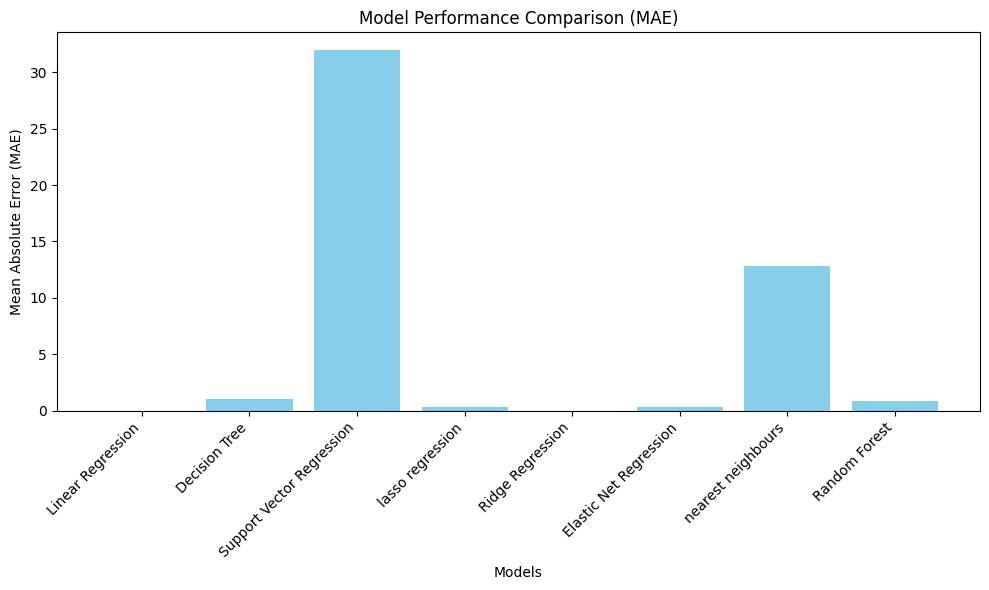

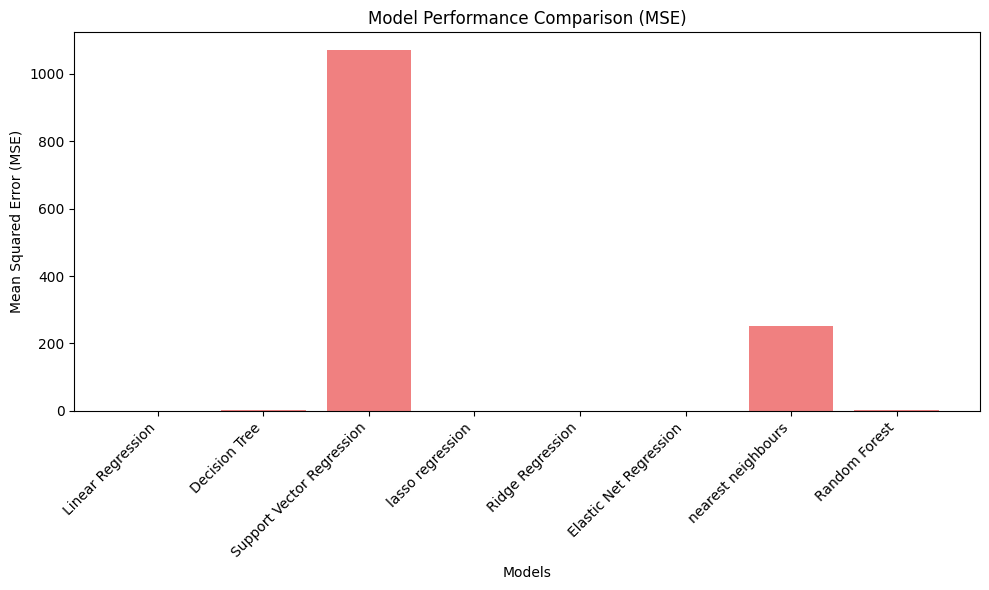

In [ ]:
# prompt: How can plot graphs with the accuracy of all the models to see which has the best accuracy

import matplotlib.pyplot as plt

# Extract MAE values for plotting
mae_values = [results[model]['MAE'] for model in results]
model_names = list(results.keys())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, mae_values, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance Comparison (MAE)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# Extract RMSE values for plotting
rmse_values = [results[model]['MSE'] for model in results]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color='lightcoral')
plt.xlabel("Models")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Performance Comparison (MSE)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#Residual Plot

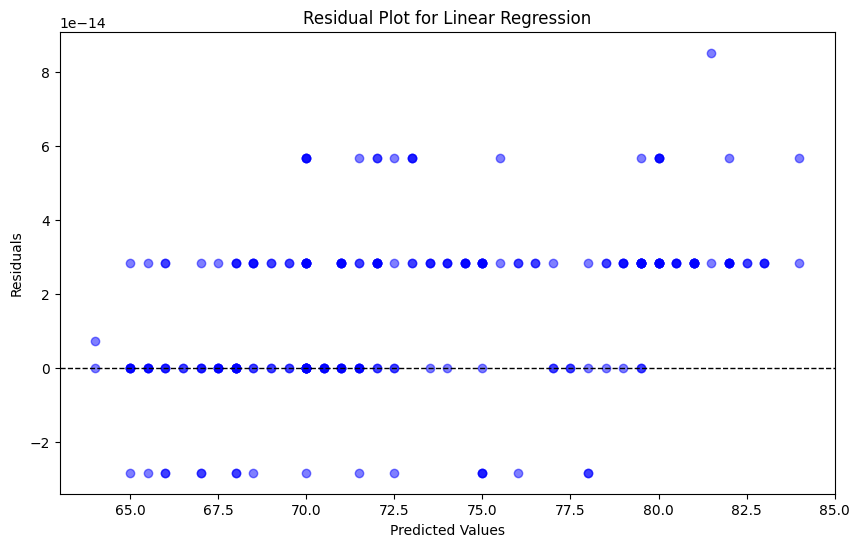

In [ ]:
import matplotlib.pyplot as plt

# Ensure Linear Regression model is present
if 'Linear Regression' in models:
    # Get the Linear Regression model
    linear_model = models['Linear Regression']

    # Predict on the test set
    y_pred = linear_model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred

    # Plot the residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, color='blue')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Linear Regression')
    plt.show()
else:
    print("Linear Regression model not found in the dictionary.")


#Plot R2 Bar Chart

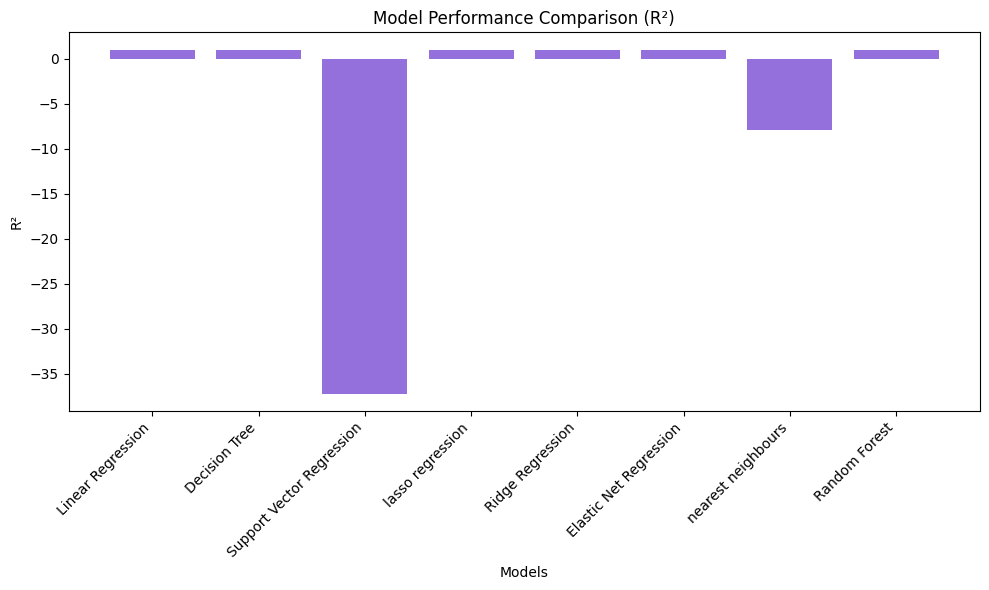

In [ ]:
# Extract R² values for plotting
r2_values = [results[model]['R²'] for model in results]

# Create the bar plot for R²
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_values, color='mediumpurple')
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model Performance Comparison (R²)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
